In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorflow.python.keras import layers
import tensorflow_probability as tfp
from tensorflow.python.keras.callbacks import Callback
from sklearn.model_selection import train_test_split


import functions.parse_data as parse
import functions.models as md
import functions.handy_functions as hf

from sklearn.metrics import mean_squared_error as MSE

from tensorflow import keras
from keras import backend as K
from scipy import stats

2024-02-08 11:25:01.152845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_water=parse.parse('SMHIdata/cloudrm_water.dat')
data_clear=parse.parse('SMHIdata/cloudrm_clear.dat')
data_ice=parse.parse('SMHIdata/cloudrm_ice.dat')
data_mixed=parse.parse('SMHIdata/cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])

print(data_all.isnull().sum().sum())

0


In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

X=df[X_labels]
y=df[y_labels]

#Divide train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [5]:
#2D loss function attempt
def QuantileLoss2D(perc, delta=1e-4):
    perc = np.array(perc).reshape(-1)
    perc.sort()
    perc = perc.reshape(1, -1)
    def _qloss(y, pred):
        I = tf.cast(tf.repeat(y, tf.size(perc), axis=1) <= pred, tf.float32)
        d = K.abs(tf.repeat(y, tf.size(perc), axis=1) - pred)
        correction = I * (1 - tf.cast(tf.tile(perc, [1,tf.shape(y)[1]]),tf.float32)) + (1 - I) * tf.cast(tf.tile(perc, [1,tf.shape(y)[1]]),tf.float32)
        # huber loss
        huber_loss = K.sum(correction * tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta), -1)
        # order loss
        q_order_loss = K.sum(K.sum(K.maximum(0.0, tf.reshape(pred,[tf.shape(y)[0],-1,tf.size(perc)])[:, :,:-1] - tf.reshape(pred,[tf.shape(y)[0],-1,tf.size(perc)])[:, :,1:] + 1e-6), -1),-1)
        return huber_loss + q_order_loss
    return _qloss

In [17]:
num_epochs=20
batch_size=100

perc_points = [0.1,0.5,0.9]
model = keras.Sequential([
    layers.Dense(32,input_dim=len(X_labels),activation='linear'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(np.size(perc_points)*len(y_labels),activation='linear')
])
model.compile(optimizer=keras.optimizers.Adam(2e-3), loss=QuantileLoss2D(perc_points))
model.fit(X_train, y_train, epochs=num_epochs, verbose=1, batch_size = batch_size)

Epoch 1/20
1800/1800 [==============================] - 9s 3ms/step - loss: 0.7803
Epoch 2/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.4681
Epoch 3/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.4299
Epoch 4/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.4071
Epoch 5/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3945
Epoch 6/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3873
Epoch 7/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3800
Epoch 8/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3740
Epoch 9/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3688
Epoch 10/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3654
Epoch 11/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3607
Epoch 12/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.3576
E

In [18]:
y_pred = model.predict(X_test)
y_pred = np.reshape(y_pred,[-1,len(y_labels),3])

625/625 [==============================] - 2s 3ms/step


In [19]:
print(np.shape(y_pred))
print(np.shape(y_test))

print(y_pred[502,2,:])
y_test = np.array(y_test)
print(y_test[502,2])

mse = MSE(y_test,y_pred[:,:,1])



(20000, 12, 3)
(20000, 12)
[0.35212153 0.39270908 0.43852597]
0.40815


0.0034008279791773537

In [20]:
outcount = 0
for i in range(np.shape(y_test)[0]):
    for j in range(np.shape(y_test)[1]):
        if y_test[i,j] < y_pred[i,j,1] or y_test[i,j] > y_pred[i,j,2]:
            outcount = outcount +1

outrate = outcount/np.size(y_test)

outrate

0.18544166666666667

In [27]:
def PSNR(y_true,y_pred):
    mse = MSE(y_true,y_pred)
    maxval = np.amax(y_true)
    PSNR = 10*np.log10((maxval)**2/mse)
    
    return PSNR

In [28]:
PSNR(y_test,y_pred[:,:,1])

2.96357


34.12045714616695

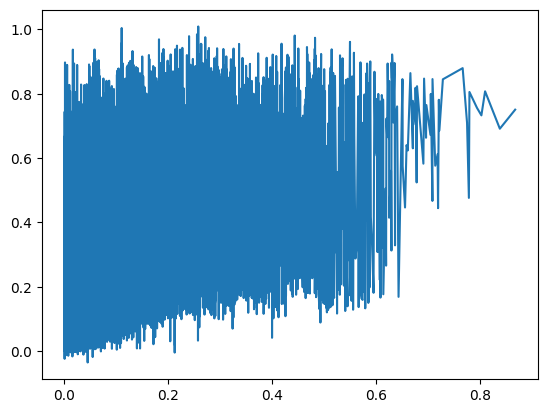

In [34]:
error = np.abs(y_test-y_pred[:,:,1]).flatten()
unc = (y_pred[:,:,2]-y_pred[:,:,0]).flatten()

errsortidx = np.argsort(error)
plt.figure()
plt.plot(error[errsortidx],unc[errsortidx])
plt.show()


In [36]:
overcount = 0
for i in range(np.shape(y_test)[0]):
    for j in range(np.shape(y_test)[1]):
        if y_test[i,j] > y_pred[i,j,1]:
            overcount = overcount +1

overrate = overcount/np.size(y_test)

overrate

0.5245291666666667

In [38]:
X_test.head()

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Cloud_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle
45499,-0.682708,-0.932522,-0.991824,-1.117428,-1.137592,-1.237753,-1.431055,-1.182353,-1.503357,-0.644625,-0.172292,-0.512962,1.448648,1.712703,0.428654
593,0.769832,0.695705,0.583289,0.475094,0.255244,-0.467927,-0.647131,-0.498173,-1.289948,-0.651518,0.137122,-0.249636,-1.634309,0.578144,-1.036206
3631,1.094795,1.062802,0.990588,0.887868,1.134125,0.174901,0.137076,-0.004912,1.224598,2.275586,-0.906481,-0.772771,-0.101133,-0.945269,-0.600740
38074,0.210618,0.186565,0.033951,0.016592,-0.154527,0.014339,-0.331302,-0.018895,-0.326390,-0.507312,-1.037603,-0.973732,-0.201115,-0.666426,0.643476
35802,0.780234,0.738989,0.527697,0.646916,0.318989,-0.551376,-0.435828,-0.627353,0.626945,0.148611,-1.030991,-0.961921,0.469971,-0.931756,-1.689128


In [47]:
test_idx = X_test.index.values
df_test = df.iloc[test_idx]
COTs = np.array(df_test['COT'])
COTsortidx = np.argsort(COTs)
COTssorted = COTs[COTsortidx]

uncs = np.mean(y_pred[:,:,2]-y_pred[:,:,0],axis=1)



In [46]:
df_test.head(10)

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,...,Clear_B12,Clear_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor
45499,-0.682708,-0.932522,-0.991824,-1.117428,-1.137592,-1.237753,-1.431055,-1.182353,-1.503357,-0.644625,...,0.79785,0.44943,1.448648,1.712703,0.428654,2.338,3,5569,0.128,3.74
593,0.769832,0.695705,0.583289,0.475094,0.255244,-0.467927,-0.647131,-0.498173,-1.289948,-0.651518,...,0.91753,0.78994,-1.634309,0.578144,-1.036206,8.440,5,6601,0.127,2.99
3631,0.240893,0.172439,0.008569,0.157544,0.013316,-0.581148,-0.789255,-0.611389,-1.430378,-0.650712,...,0.81462,0.64592,0.502419,0.336021,-0.306978,12.230,3,7033,0.126,5.40
38074,-0.277164,-0.612951,-0.778452,-0.503020,-0.926926,-1.616336,-1.474526,-1.504315,-0.819118,-0.624664,...,0.87039,0.76815,-1.558601,1.694783,0.763308,20.980,2,303,0.111,0.78
35802,1.434430,1.308934,1.096584,0.959114,0.766302,-0.053839,-0.186798,-0.141567,-0.548646,-0.648470,...,0.93740,0.86294,0.367464,-0.172837,1.499747,29.560,4,6308,0.127,2.08
20702,-0.144346,-0.106612,-0.234392,-0.239116,-0.418458,0.253100,0.364158,0.339533,-0.623893,-0.653516,...,0.59006,0.42107,-0.158866,-1.324579,0.504747,10.876,2,8402,0.117,2.08
42546,-0.686262,-0.596292,-0.372399,-0.726034,-0.234960,0.262398,-0.035399,0.179985,-0.848524,-0.586635,...,0.80385,0.56104,0.241386,-0.607567,-0.978227,3.663,5,6518,0.106,3.43
27617,-0.372130,-0.298889,-0.201478,-0.378750,-0.155430,0.455672,0.475648,0.260174,0.715597,-0.484879,...,0.76249,0.55482,-0.923372,-0.873896,-1.131078,6.786,2,9595,0.123,0.25
28123,0.474219,0.350909,0.172453,0.312616,-0.029766,-0.650915,-0.649030,-0.673093,0.180027,0.254997,...,0.90158,0.64684,-1.545334,0.909770,-0.280107,49.995,4,6221,0.127,3.64
3386,0.229613,0.041434,-0.137995,0.031643,-0.343531,-0.990563,-0.898346,-0.917691,-0.148543,-0.332414,...,0.61930,0.38157,-0.050719,1.250550,0.085220,49.597,3,7202,0.128,4.26


0.05618247
0.10144738
